## Install Pycaret
PyCaret is an open-source, low-code machine learning library built-in Python for automating machine learning workflows. 

In [1]:
#Install pycaret
!pip install pycaret

In [2]:
# upgrade statmodels
!pip install statsmodels --upgrade

## Import Dataset and Dependencies

In [3]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

from datetime import datetime
from sklearn.metrics import mean_absolute_error
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
# IMPORT DATA FROM Google drive 

# You can just umcomment the below code to read the data from your drive
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Data/fred_quarterly.csv')


In [6]:
train

,date,month,quarter,Target,gnp,gdpdef,gdp
0,1/1/2000,2000-01,2000Q1,12935.252,10035.263,77.325,10002.179
1,4/1/2000,2000-04,2000Q2,13170.749,10283.391,77.807,10247.720
2,7/1/2000,2000-07,2000Q3,13183.890,10348.645,78.263,10318.165
3,10/1/2000,2000-10,2000Q4,13262.250,10490.430,78.688,10435.744
4,1/1/2001,2001-01,2001Q1,13219.251,10510.297,79.204,10470.231
...,...,...,...,...,...,...,...
81,4/1/2020,2020-04,2020Q2,17258.205,19649.442,112.859,19477.444
82,7/1/2020,2020-07,2020Q3,18560.774,21365.412,113.888,21138.574
83,10/1/2020,2020-10,2020Q4,18767.778,21728.223,114.439,21477.597
84,1/1/2021,2021-01,2021Q1,19055.655,22273.060,115.652,22038.226


## Data Preprocessing
This step includes 
  * Feature Engineering and Feature Selection
  * Splitting the data for train and test

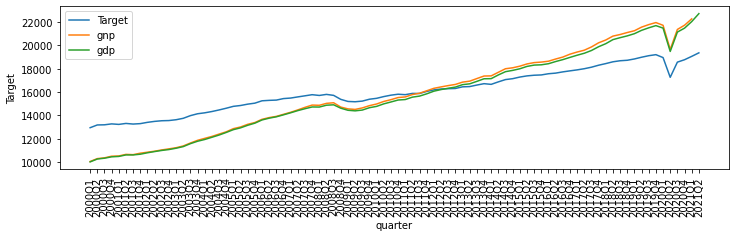

In [7]:
# Lets visualise some of the featurs vs time
# The features are : Target, gnp,gdp
plt.figure(figsize=(12,3))
sns.lineplot(train['quarter'],train['Target'])
sns.lineplot(train['quarter'],train['gnp']) 	
sns.lineplot(train['quarter'],train['gdp'])
plt.legend(['Target','gnp','gdp'])
plt.xticks(rotation=90)
plt.grid(False)
plt.show()

*  We are considering this problem as a univariate time series forecasting, ie, we don't need any time dependable variables other than target variable.So we just drop all other time dependable variables like gdp , gnp

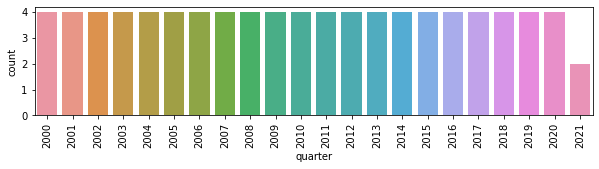

In [8]:
# checking whether any quarter result missing 
plt.figure(figsize=(10,2))
sns.countplot(train['quarter'].apply(lambda x:x.split('Q')[0]))
plt.xticks(rotation=90)
plt.show()

* There is no missing values in the quarter results. 

### Feature Engineering

In [9]:
# Split the date feature into Year and Quarter
train['year'] = train['quarter'].apply(lambda x : x.split('Q')[0]).astype(int)
train['quarter_'] = train['quarter'].apply(lambda x : x.split('Q')[1]).astype(int)

# Create a new feature with bias for covid affected quarters
train['Covid_flag'] = pd.Series(np.where(train['year'] >=2020, 5, 1))

# Set index of the quarter
train = train.set_index('quarter')

* Shift the target variables  to get multiple lag features and the new dependent feature

In [10]:
# Lag features for the target variable
train['lag_1'] = train['Target'].shift(1)  # Lag 1
train['lag_2'] = train['Target'].shift(2)  # Lag 2
train['lag_4'] = train['Target'].shift(4)  # Lag 3
# Drop firt four observations
train.drop(train.index[0:4],inplace=True)

* While shifting Target variables for new dependent feature,few of the top obervations turned to be NaN. So we could drop that observations

* We have added some new dependant features for forecasting - lag_1,lag_2,lag_4,covid_flag
* Drop the time depandanat variables from dataset since it is univariate time forecasting

In [11]:
# Select the feature needed for the time series
df  = train[['year','quarter_','lag_1','lag_2','lag_4','Covid_flag','Target']]

In [12]:
df.drop(df.index[0:4],inplace=True)

In [13]:
#Check for the  Missing values
df.isnull().sum().any()

False

* There is no missing values in the dataset

### Split the data for trainig and testing

* Time series data has to follow the order of the observations, so splitting the dataset for trainig and testing is very simple. We have to fit the model for the data till a particular time,it is called training dataset. The dataset used to check the model's perfomance called testing dataset which will be the continuation of the training dataset.
* Here we are taking the last few quarters as testing data and all the data before it is for fitting the model

In [14]:
# We can decide any boundary for training and testing 
def train_test_split(data,split_year,split_quarter):
  ''' This function return the traing and testing dataset for model 
      Input : data - the whole dataset
              split_year - boundary for the train-test split
      ie, the dataset before split_year is train data and after split_year is test data  
  '''
  df_train = data[data['year']<split_year]
  df_test = data[data['year']>=split_year]
  return df_train,df_test

In [15]:
# Split the data with decision boundary 2021 
df_train ,df_test = train_test_split(df,2017,1)

## Create Model

In [16]:
# import regeression models pycaret
from pycaret.regression import *

In [17]:
# Setting up the model
reg = setup(data = df_train, target = 'Target',
              train_size = 0.9, 
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
              silent = True,verbose = False, session_id = 123)

Setup function parameters:
* data - Dataset for fitting the model
* target - Name of the target column (dependant variable)
* train_size - Split ratio for train and test for model fitting
* data_split_shuffle - Given 'False' to avoid the shuffle before splitting
* fold_strategy - Using 'time_series'  as cross fold strategy
* fold - Number of folds to be used for cross validation
* verbose - Information grid will not print if it is False

In [18]:
# Select best model based on lowest Mean absolute error
best = compare_models(sort='MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,7.906220e+01,1.341925e+04,1.095233e+02,7.872000e-01,0.0069,0.0050,0.0267
omp,Orthogonal Matching Pursuit,9.395710e+01,1.741816e+04,1.237831e+02,7.200000e-01,0.0078,0.0059,0.0167
llar,Lasso Least Angle Regression,1.000734e+02,1.832148e+04,1.314766e+02,7.290000e-01,0.0083,0.0063,0.0167
lasso,Lasso Regression,1.118658e+02,2.426261e+04,1.404452e+02,5.868000e-01,0.0089,0.0071,0.0233
en,Elastic Net,1.220103e+02,2.637119e+04,1.544839e+02,5.931000e-01,0.0098,0.0077,0.0200
ridge,Ridge Regression,1.256889e+02,2.687529e+04,1.538290e+02,5.680000e-01,0.0097,0.0079,0.0167
br,Bayesian Ridge,1.245878e+02,2.726556e+04,1.566320e+02,5.744000e-01,0.0099,0.0079,0.0167
par,Passive Aggressive Regressor,1.390273e+02,4.048007e+04,1.894707e+02,4.113000e-01,0.0120,0.0089,0.0167
dt,Decision Tree Regressor,4.529930e+02,3.040324e+05,5.377100e+02,-2.694800e+00,0.0338,0.0281,0.0167
ada,AdaBoost Regressor,5.050931e+02,3.738665e+05,5.869488e+02,-3.700000e+00,0.0370,0.0313,0.0767


#### Create Baseline model

In [19]:
#Create_model
model = create_model('huber')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,106.8930,26303.6681,162.1841,0.4826,0.0104,0.0069
1,68.0086,8221.8936,90.6747,0.9200,0.0058,0.0044
2,62.2850,5732.1914,75.7112,0.9590,0.0045,0.0037
Mean,79.0622,13419.2510,109.5233,0.7872,0.0069,0.0050
SD,19.8176,9167.1808,37.7345,0.2159,0.0025,0.0014


In [20]:
# tune model
tuned_model = tune_model(model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,103.7111,25230.2706,158.8404,0.5038,0.0102,0.0067
1,67.3475,7707.7585,87.7938,0.9250,0.0057,0.0043
2,64.9673,5712.3931,75.5804,0.9591,0.0045,0.0039
Mean,78.6753,12883.4741,107.4049,0.7960,0.0068,0.0050
SD,17.7296,8768.4247,36.7106,0.2071,0.0024,0.0012


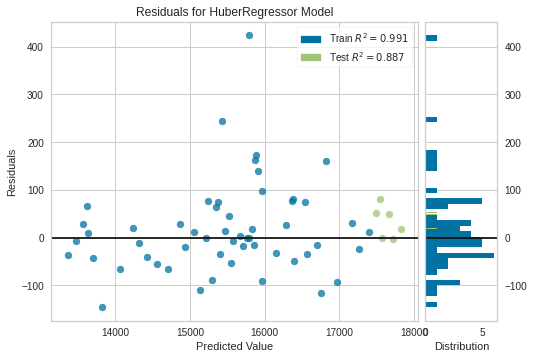

In [21]:
# residues for HuberRegressor 
plot_model(tuned_model)

In [22]:
# Let's create MAPE error function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
# generate predictions on the original dataset
predictions_train = predict_model(tuned_model, data=df_train)# add a date column in the dataset
predictions_test = predict_model(tuned_model, data=df_test)# add a date column in the dataset
# Mean absolute error of the model
mae_train = mean_absolute_percentage_error(predictions_train['Target'],predictions_train['Label'])
mae_test = mean_absolute_percentage_error(predictions_test['Target'],predictions_test['Label'])
print('Mean absolute percentage error for train data is ', mae_train)
print('Mean absolute percentage error for test data is ', mae_test)

Mean absolute percentage error for train data is  0.38998950050941045
Mean absolute percentage error for test data is  1.3145360011968978


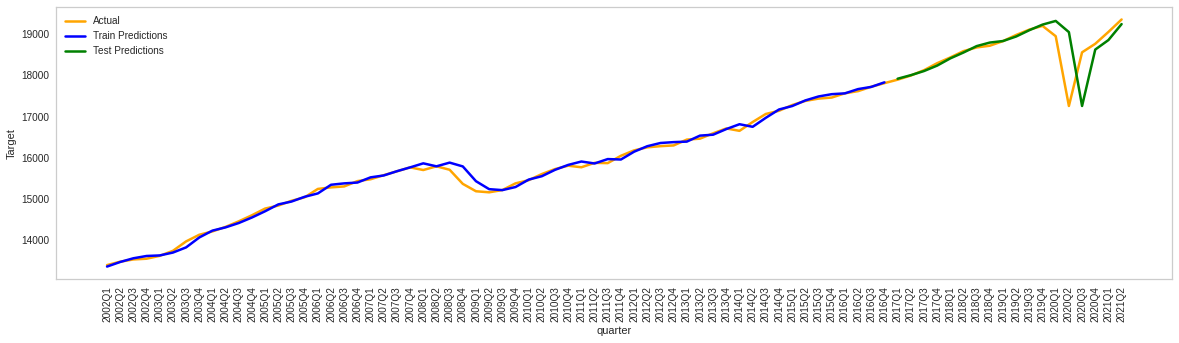

In [24]:
# Plot the predicted output for train and test dataset
plt.figure(figsize=(20,5))

# Lineplot for Train Predictions
sns.lineplot(df.index, df['Target'], 
             color='Orange',label='Actual',linewidth=2.5)

# Lineplot for Train Predictions
sns.lineplot(predictions_train.index, predictions_train['Label'], 
             color='blue',label='Train Predictions',linewidth=2.5)
# Lineplot for Test Predictions
sns.lineplot(predictions_test.index, predictions_test['Label'], 
             color='green',label='Test Predictions',linewidth=2.5)


plt.xticks(rotation=90)
plt.grid(False)
plt.show()

## Predict Upcoming Quarter Results


In [25]:
# Lets run the model using whole dataset since we dont need any test data
# Setting up the model 
reg = setup(data = df, target = 'Target',
              train_size = 0.9, 
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
              silent = True, verbose = False, session_id = 123)
#create a model
model_final = create_model('huber',verbose=False)
# Tune model
tuned_model_final = tune_model(model_final,verbose=False)

In [26]:
#Predict on the whole dataset
predictions_final = predict_model(tuned_model_final, data=df)

In [27]:
# Let's create the features for the next n quarters
def data_gen(year,quarter,predictions_final):
  ''' This function return the feature for upcoming quarters
       Features :  year, quarter,lag_1 ,lag_2 ,lag_3 ,' ' , 'covid_flag  '''
  data_ = pd.DataFrame([[year,quarter,predictions_final['Target'].iloc[-1],
                        predictions_final['Target'].iloc[-2],predictions_final['Target'].iloc[-4],' ',5]],
                        columns=df.columns,index=[str(year)+'Q'+str(quarter)])
  return data_

In [28]:
# Predict next n quarter results
def quarter_results(n,predictions_final):
  ''' This function returns the prediction of upcoming n quarters
      Input : n - No of quarters to be predicted
              prediction_final - Output of training dataset   '''
              
  current_year =  predictions_final['year'].iloc[-1]
  current_quarter  = predictions_final['quarter_'].iloc[-1]
  for i in range(1,n+1):
    current_quarter = current_quarter + 1
    if current_quarter%5 == 0:
      current_quarter = 1
      current_year = current_year + 1
    data_ = data_gen(current_year,current_quarter,predictions_final)
    data_ = predict_model(tuned_model_final,data_)
    data_['Target'] = data_['Label']
    predictions_final = pd.concat([predictions_final,data_])
  return predictions_final.iloc[-n:]

In [29]:
# Let's predict for the next 6 quarters
future_prediction = quarter_results(10,predictions_final)

In [30]:
# Save ouput as csv file
future_prediction[['Label']].to_csv('Prediciton.csv')